This example conducts walks through plotting of GHI and WPD errors from the optwrf database.

Last Updated by Jeffrey Sward on Sept 30, 2020.

In [1]:
import csv
import datetime
import math
import random
import sys
import time

import shap
import seaborn as sns
import pandas as pd
# import prince
import numpy as np
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from optwrf.wrfparams import num2name
from optwrf.helper_functions import date2season

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

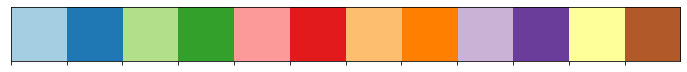

In [2]:
cmap1 = sns.color_palette('Paired', 12)
sns.palplot(cmap1)

In [3]:
# Read in the optwrf csv data file 
dateparse = lambda x: pd.datetime.strptime(x, '%b %d %Y')
data = pd.read_csv('./db_snapshots/optwrf_database_FINAL_exp02.csv', parse_dates=['start_date'], date_parser=dateparse)
# Replace missing data with NaN values
data['fitness'].values[data['fitness'] > 1 * 10 ** 23] = np.nan
data['ghi_error'].values[data['ghi_error'] > 1 * 10 ** 23] = np.nan
data['wpd_error'].values[data['wpd_error'] > 1 * 10 ** 23] = np.nan
# Determine the season
data['season'] = [date2season(dat) for dat in data.start_date]
data.sort_values(by='fitness').iloc[:5,:]

# Drop the rows that were created by error. 
# I think this error arose during the time when I was forcing wrfout data processing,
# Therefore, some fitness values were calculated based upon incomple simulations --
# rather than the full 24h...
# I manually checked the REAL top 7 (top 5 distinct parameter combinations) that show up below. 
data_corr = data.drop([1383, 1394, 1400, 1320])
data_corr.sort_values(by='fitness').iloc[:10,:]

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


,start_date,mp_physics,ra_lw_physics,ra_sw_physics,sf_surface_physics,bl_pbl_physics,cu_physics,sf_sfclay_physics,fitness,ghi_error,wpd_error,runtime,season
1823,2011-12-13,19,4,4,7,8,99,1,7858.155964,5905.98,9890490.0,00h 47m 53s,winter
1678,2011-01-14,19,4,4,7,8,99,1,7859.014414,7366.20,7469159.5,01h 26m 12s,winter
1546,2011-12-13,8,4,1,7,8,1,1,8206.917441,6285.07,10156387.0,01h 37m 22s,winter
1158,2011-12-02,13,4,4,7,8,99,1,8479.804871,6300.34,10608263.0,01h 19m 03s,winter
2285,2011-01-14,19,4,1,7,8,99,1,8487.973471,8308.79,7531930.0,00h 00m 00s,winter
2094,2011-12-02,19,4,4,7,8,99,1,8519.195161,6520.63,10369682.0,00h 42m 37s,winter
1893,2011-01-14,19,4,3,7,8,1,1,8601.927235,8344.39,7748128.5,00h 00m 00s,winter
1604,2011-12-01,8,4,1,7,8,1,1,8605.085565,5817.64,11613000.0,01h 11m 55s,winter
2222,2011-12-17,19,4,4,7,8,99,1,8634.652557,6224.43,11292114.0,00h 00m 00s,winter
1838,2011-12-17,8,4,1,7,8,99,1,8675.862289,6335.51,11226029.0,00h 54m 41s,winter


## Plots of each physics paramerization option vs. fitness

In [4]:
# Sort data by start_date to make the plots look cleaner
data = data.sort_values(by='start_date')
data

,start_date,mp_physics,ra_lw_physics,ra_sw_physics,sf_surface_physics,bl_pbl_physics,cu_physics,sf_sfclay_physics,fitness,ghi_error,wpd_error,runtime,season
181,2011-01-01,14,5,99,3,9,7,10,NaN,NaN,NaN,00h 00m 00s,winter
2190,2011-01-01,8,4,1,7,8,1,1,16914.652432,5856.72,31429570.0,00h 00m 00s,winter
61,2011-01-01,1,99,3,7,6,14,5,NaN,NaN,NaN,00h 00m 10s,winter
1934,2011-01-01,19,4,1,7,8,1,1,17038.881937,6175.75,31251868.0,00h 00m 00s,winter
1875,2011-01-02,19,4,4,7,8,99,1,14985.988418,6127.48,26445874.0,00h 00m 00s,winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1895,2011-12-29,19,4,3,7,8,99,1,13323.083449,5884.37,22901682.0,00h 00m 00s,winter
1364,2011-12-29,19,4,4,7,8,1,1,13461.207440,5908.82,23193046.0,00h 00m 00s,winter
1281,2011-12-30,8,5,1,7,8,1,1,11675.691333,6158.70,18584116.0,04h 00m 32s,winter
945,2011-12-30,28,4,3,5,1,99,2,NaN,NaN,NaN,00h 00m 00s,winter


In [5]:
def format_plot(xlab='xlabel', ylab='ylabel'):
    # find and format dates
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    date_fmt = mdates.DateFormatter('%b')

    # format the ticks
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(date_fmt)
    ax.xaxis.label.set_fontsize(14)
    ax.yaxis.label.set_fontsize(14)

    # round to nearest month
    datemin = np.datetime64(data['start_date'].iloc[0], 'm')
    datemax = np.datetime64(data['start_date'].iloc[-1], 'm') + np.timedelta64(1, 'm')
    ax.set_xlim(datemin, datemax)

    # format the coords message box
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.grid(True)

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    fig.autofmt_xdate()
    
    # format x and y labels
    plt.xlabel(xlab, fontsize=18)
    plt.ylabel(ylab, fontsize=18)

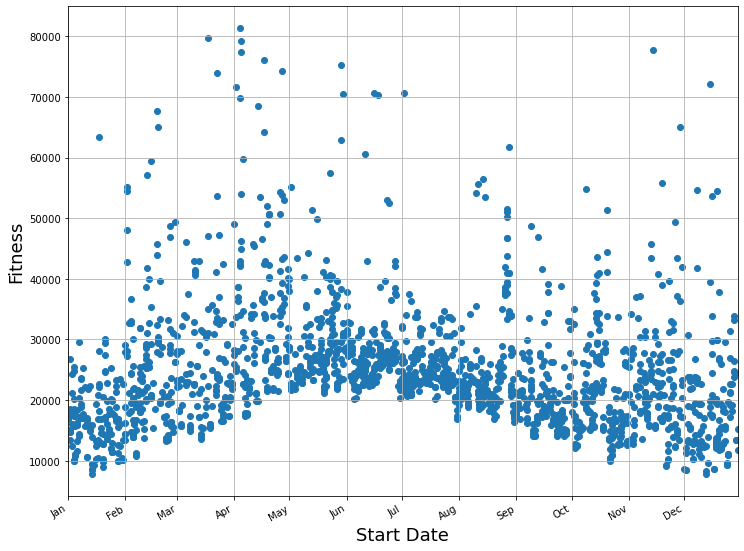

In [10]:
# Plot start_date vs fitness
fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(data_corr.start_date, data_corr.fitness, label='Uncorrected fitness')
format_plot('Start Date', 'Fitness')
# ax.legend()
# fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate.pdf'
# plt.savefig(fig_path, transparent=True, bbox_inches='tight')

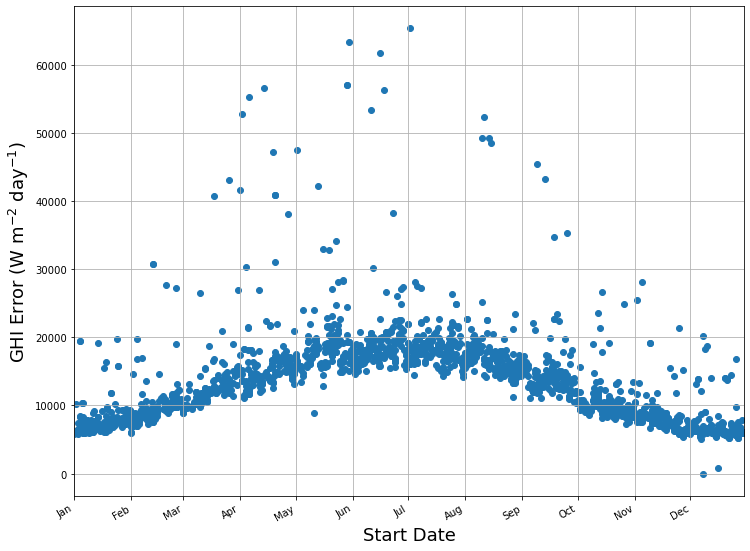

In [11]:
# Plot start_date vs ghi_error
fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(data_corr.start_date, data_corr.ghi_error)
format_plot('Start Date', 'GHI Error (W m$^{-2}$ day$^{-1}$)')
# ax.legend()

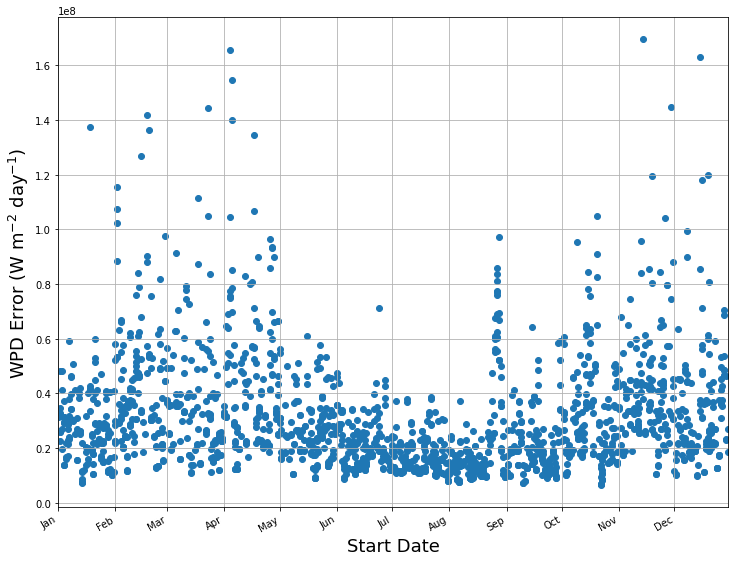

In [12]:
# Plot start_date vs ghi_error
fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(data_corr.start_date, data_corr.wpd_error)
format_plot('Start Date', 'WPD Error (W m$^{-2}$ day$^{-1}$)')

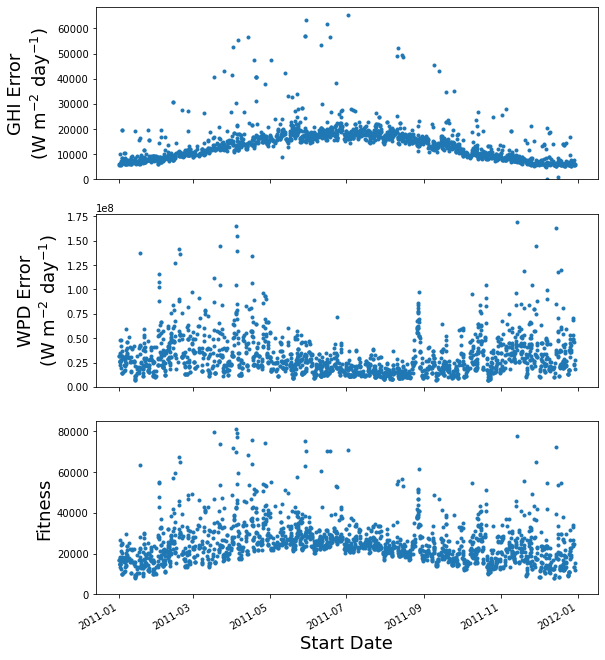

In [33]:
# Now, create the above three plots in the same frame
# Create a figure
fig = plt.figure(figsize=(9,12))

# Create the GHI error plot
ax_ghierr = fig.add_subplot(3,1,1)
plt.setp(ax_ghierr.get_xticklabels(), visible=False)  # make these tick labels invisible
ax_ghierr.scatter(data_corr.start_date, data_corr.ghi_error, marker='.')
format_plot('Start Date', 'GHI Error\n(W m$^{-2}$ day$^{-1}$)')
ax_ghierr.set_ylim(0)

# Create the WPD error plot
ax_wpderr = fig.add_subplot(3,1,2, sharex=ax_ghierr)
plt.setp(ax_wpderr.get_xticklabels(), visible=False)  # make these tick labels invisible
ax_wpderr.scatter(data_corr.start_date, data_corr.wpd_error, marker='.')
format_plot('Start Date', 'WPD Error\n(W m$^{-2}$ day$^{-1}$)')
ax_wpderr.set_ylim(0)

# Create the fitness plot
ax_fitness= fig.add_subplot(3,1,3, sharex=ax_wpderr)
ax_fitness.scatter(data_corr.start_date, data_corr.fitness, marker='.')
format_plot('Start Date', 'Fitness')
ax_fitness.set_ylim(0)

fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/GHI_WPD_Err_Fitness_summary_plot'
plt.savefig(fig_path + '.pdf', transparent=True, bbox_inches='tight')
plt.show()

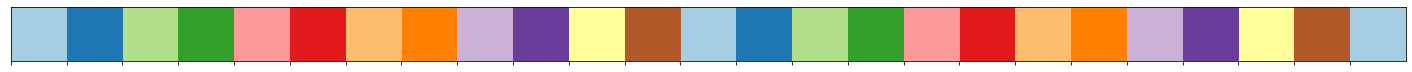

In [9]:
cmap1 = sns.color_palette('Paired', 25)
sns.palplot(cmap1)

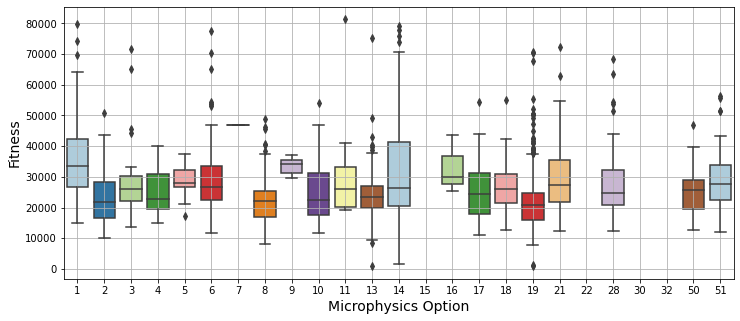

In [11]:
# Plot microphysics option vs. fitness
fig, ax = plt.subplots(figsize=(12, 5))
# sns.catplot(x='mp_physics', y='fitness', data=data, palette=cmap1)
# sns.boxplot(x='mp_physics', y='fitness', data=data, palette='Greys')
sns.boxplot(x='mp_physics', y='fitness', data=data, palette=cmap1)

plt.xlabel('Microphysics Option', fontsize=18)
plt.ylabel('Fitness', fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.grid(True)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Fitnessvmp.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


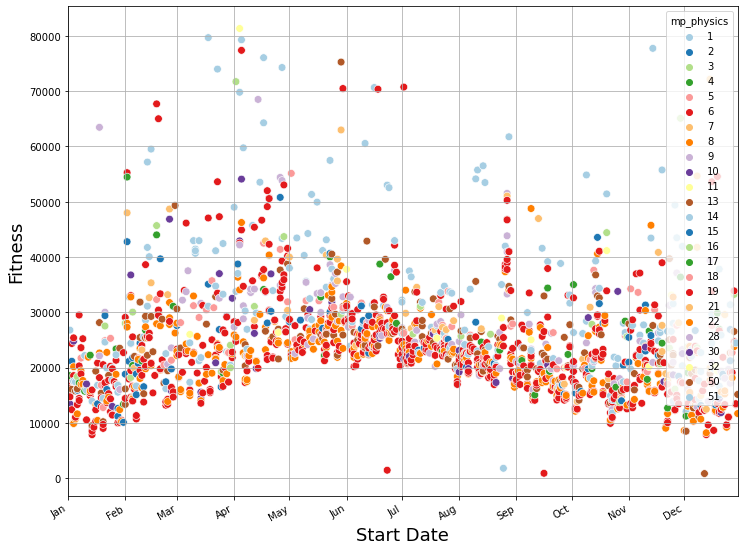

In [12]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(data.start_date, data.fitness, hue=data.mp_physics, legend='full', palette=cmap1, s=60)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate_mp.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

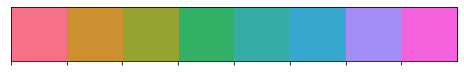

In [13]:
cmap2 = sns.husl_palette(8)
sns.palplot(cmap2)

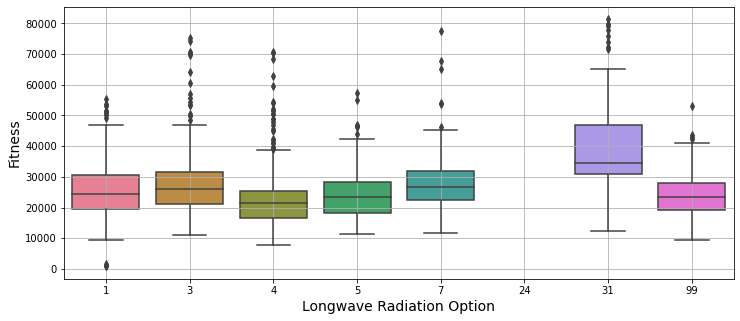

In [14]:
# Plot longwave radiation option vs. fitness
fig, ax = plt.subplots(figsize=(12, 5))
# sns.catplot(x='ra_lw_physics', y='fitness', data=data, palette=cmap2)
# sns.boxplot(x='ra_lw_physics', y='fitness', data=data, palette='Greys')
sns.boxplot(x='ra_lw_physics', y='fitness', data=data, palette=cmap2)
plt.xlabel('Longwave Radiation Option', fontsize=18)
plt.ylabel('Fitness', fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.grid(True)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Fitnessvralw.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


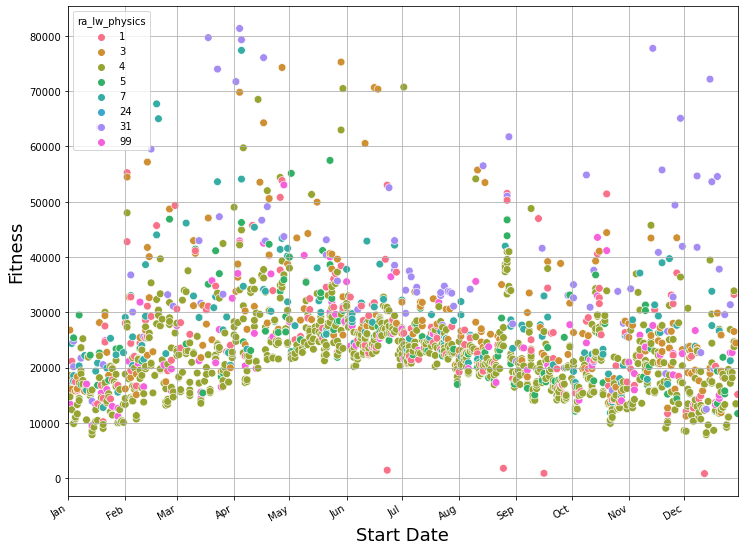

In [15]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(data.start_date, data.fitness, hue=data.ra_lw_physics, legend="full", palette=cmap2, s=60)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate_ralw.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

In [16]:
# Paired; n = 8; desat = 0.60
cmap3 = sns.choose_colorbrewer_palette('qualitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

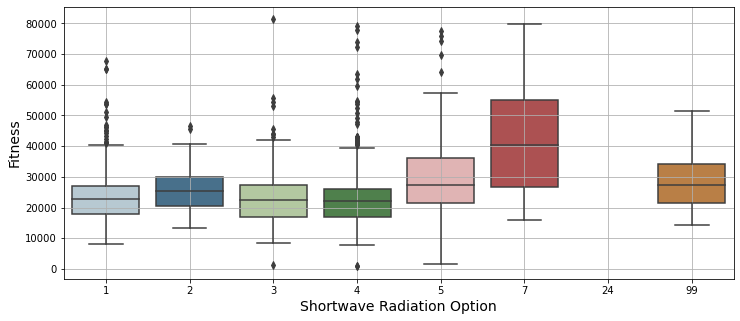

In [17]:
# Plot shortwave radiaiton option vs. fitness
fig, ax = plt.subplots(figsize=(12, 5))
# sns.catplot(x='ra_sw_physics', y='fitness', data=data, palette=cmap3)
# sns.boxplot(x='ra_sw_physics', y='fitness', data=data, palette='Greys')
sns.boxplot(x='ra_sw_physics', y='fitness', data=data, palette=cmap3)
plt.xlabel('Shortwave Radiation Option', fontsize=18)
plt.ylabel('Fitness', fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.grid(True)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Fitnessvrasw.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


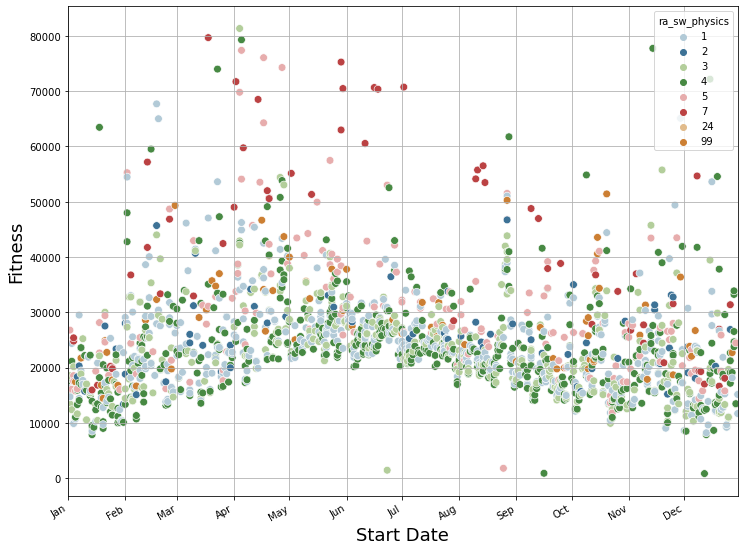

In [18]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(data.start_date, data.fitness, hue=data.ra_sw_physics, legend="full", palette=cmap3, s=60)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate_rasw.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

In [19]:
# Set2; n = 6; desat = 0.80
cmap4 = sns.choose_colorbrewer_palette('qualitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

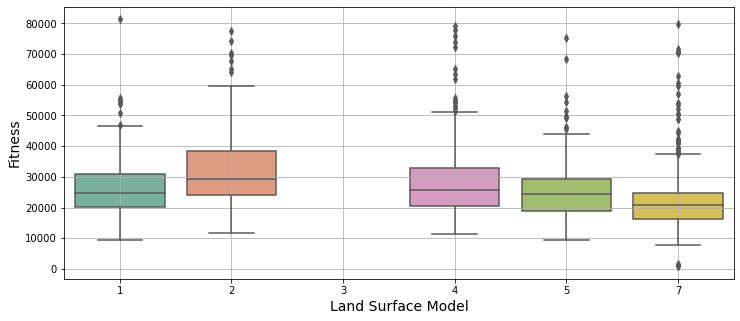

In [20]:
# Plot surface physics option vs. fitness
fig, ax = plt.subplots(figsize=(12, 5))
# sns.catplot(x='sf_surface_physics', y='fitness', data=data, palette=cmap4)
# sns.boxplot(x='sf_surface_physics', y='fitness', data=data, palette='Greys')
sns.boxplot(x='sf_surface_physics', y='fitness', data=data, palette=cmap4)
plt.xlabel('Land Surface Model', fontsize=18)
plt.ylabel('Fitness', fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.grid(True)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Fitnessvlsm.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


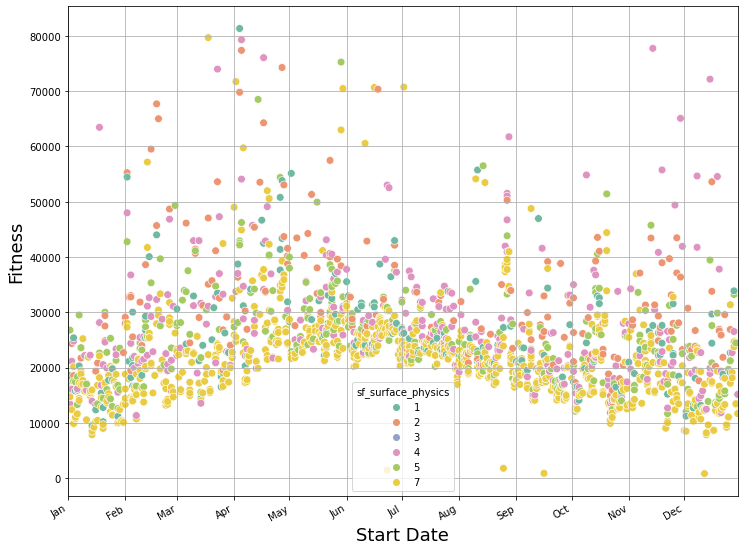

In [21]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(data.start_date, data.fitness, hue=data.sf_surface_physics, legend="full", palette=cmap4, s=60)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate_lsm.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

In [22]:
# Accent; n = 11; desat = 0.70
cmap5 = sns.choose_colorbrewer_palette('qualitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

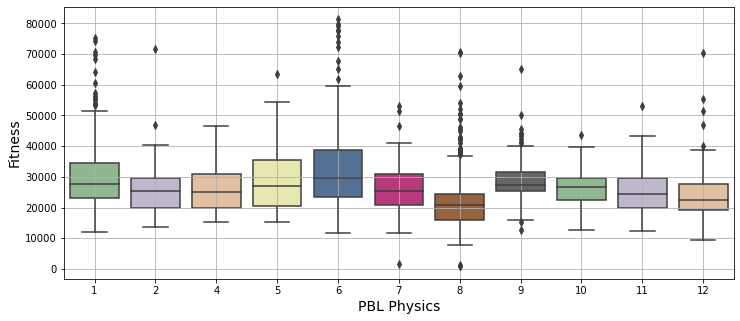

In [23]:
# Plot planetary boundary layer option vs. fitness
fig, ax = plt.subplots(figsize=(12, 5))
# sns.catplot(x='bl_pbl_physics', y='fitness', data=data, palette=cmap5)
# sns.boxplot(x='bl_pbl_physics', y='fitness', data=data, palette='Greys')
sns.boxplot(x='bl_pbl_physics', y='fitness', data=data, palette=cmap5)
plt.xlabel('PBL Physics', fontsize=18)
plt.ylabel('Fitness', fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.grid(True)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Fitnessvpbl.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


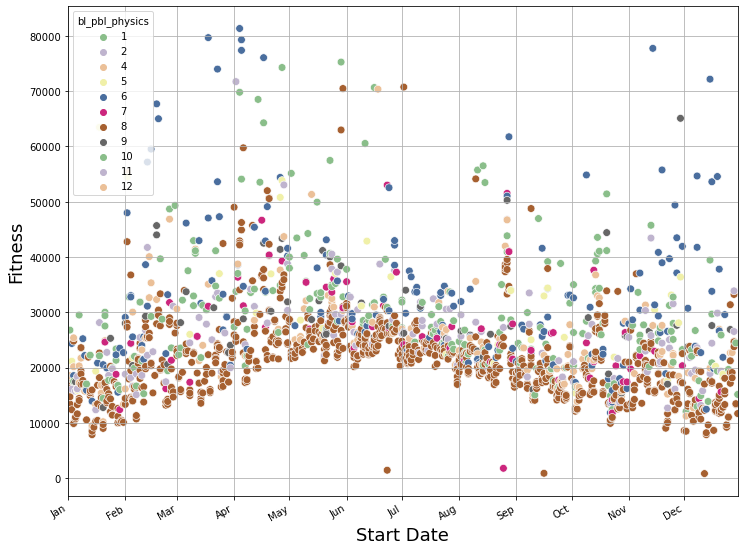

In [24]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(data.start_date, data.fitness, hue=data.bl_pbl_physics, legend="full", palette=cmap5, s=60)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate_pbl.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

In [25]:
# Dark2; n = 14; desat = 0.9
cmap6 = sns.choose_colorbrewer_palette('qualitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

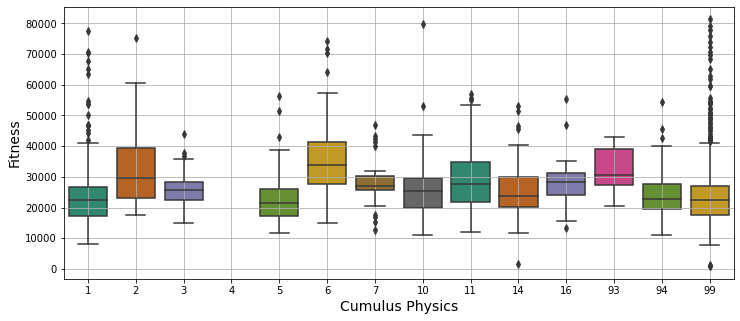

In [26]:
# Plot cumulus option vs. fitness
fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(x='cu_physics', y='fitness', data=data, palette=cmap6)
plt.xlabel('Cumulus Physics', fontsize=18)
plt.ylabel('Fitness', fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.grid(True)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Fitnessvcu.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


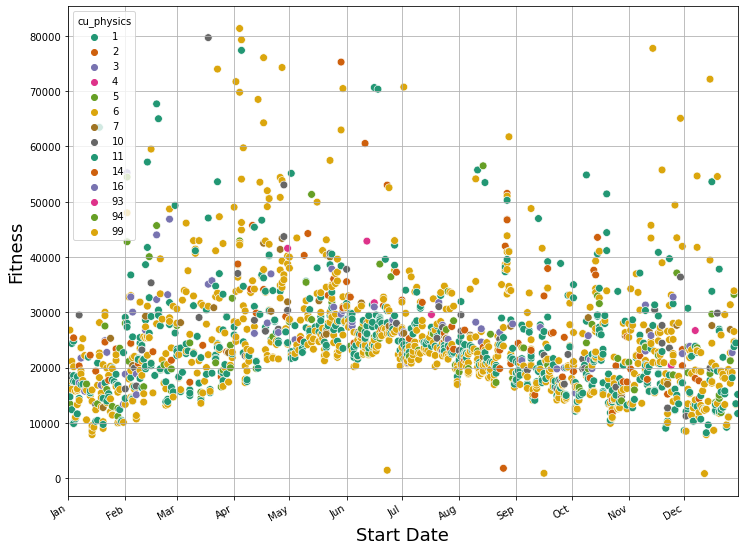

In [27]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(data.start_date, data.fitness, hue=data.cu_physics, legend="full", palette=cmap6, s=60)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate_cu.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

In [28]:
# Set1; n = 5; desat = 1.00
cmap7 = sns.choose_colorbrewer_palette('qualitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

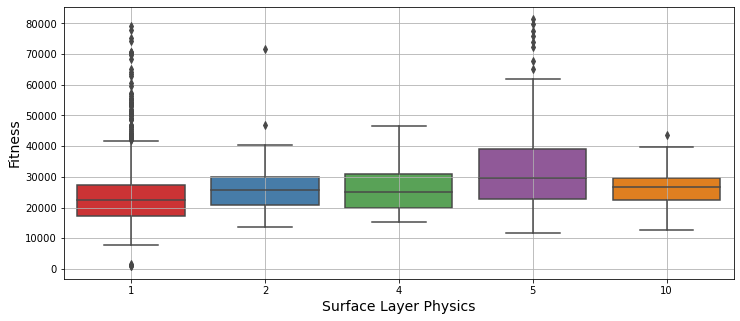

In [29]:
# Plot surface layer option vs. Fitness
fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(x='sf_sfclay_physics', y='fitness', data=data, palette=cmap7)
plt.xlabel('Surface Layer Physics', fontsize=18)
plt.ylabel('Fitness', fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.grid(True)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Fitnessvsfclay.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


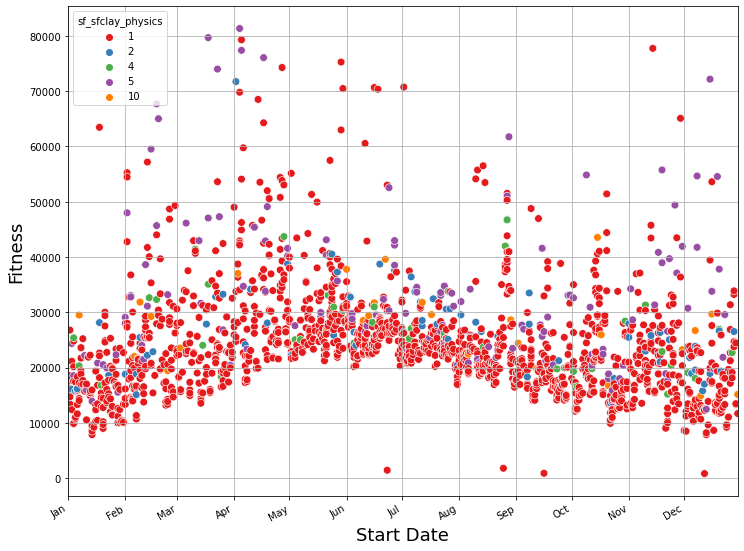

In [30]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(data.start_date, data.fitness, hue=data.sf_sfclay_physics, legend="full", palette=cmap7, s=60)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate_sfclay.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

Text(0, 0.5, 'Fitness')

Glyph 9 missing from current font.
Glyph 9 missing from current font.


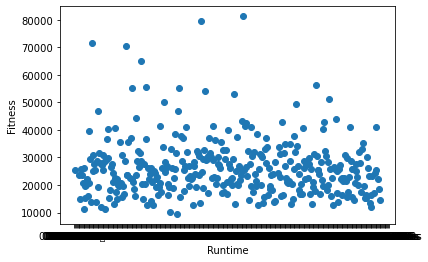

In [57]:
# Plot runtime vs fitness
data = data.sort_values(by='runtime')

fig, ax = plt.subplots()
plt.scatter(data.runtime, data.fitness)
plt.xlabel('Runtime')
plt.ylabel('Fitness')

## Heatmap showing the overall correlation matrix

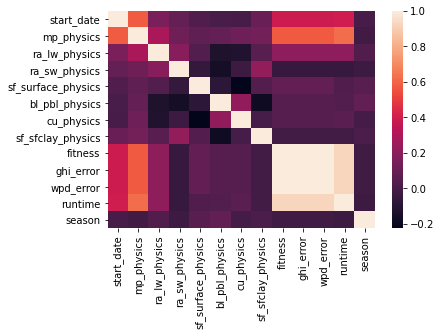

In [56]:
# Plot an overall heatmap
corr_matrix = data.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
sns.heatmap(corr_matrix)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Heatmap_overall.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')